# ESS calibration and Refitting Example
This notebook:
1. performs a trial refitting procedure from the AHFE data aggregated in `agg_freesolv_data.pkl`
2. uses refitting procedure to calibrate the ESS with bootstrapping and plots total error as function of ESS.
3. generates cartoon plots of \Theta trust region and shifting one-dimensional probability distribution.
4. runs


In [1]:
import jax
jax.config.update("jax_enable_x64", True)
devices = jax.devices()
import pickle
import os
import numpy as np
import typing
import functools
import itertools
import scipy
import tqdm
from jax import numpy as jnp
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42  # save text as font, not path

from timemachine.fe.refitting import Wrapper, BETA, load_pkl_data, embedding_pca, ESS_from_delta_us, abs_dg_reweighting_zwanzig
from timemachine.constants import KCAL_TO_KJ
from timemachine.datasets.utils import fetch_freesolv
from timemachine.fe.refitting import compute_95_ci_ecdf

The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
2024-12-09 10:55:30.907859: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
devices

[cuda(id=0)]

In [3]:
# load freesolv agg data
data = load_pkl_data('agg_freesolv_data.pkl')
(out_names, arr_exp_dGs, arr_calc_dGs, prefactors, tm_ligand_charges, es, ss, hs) = data # not padded

# convert to reduced units since corrections are also reduced
arr_exp_dGs = arr_exp_dGs * KCAL_TO_KJ * BETA
arr_calc_dGs = arr_calc_dGs * KCAL_TO_KJ * BETA

In [4]:
# compute the `cumsum` of the atom embeddings to determine when half of variance is accounted for.
stacked_hs = np.vstack(hs)
eigenvalues, eigenvectors = embedding_pca(stacked_hs)
eigenvalues_cumsum = np.cumsum(eigenvalues)
sum_eigs = np.sum(eigenvalues)

# retrieve idx that is just >=0.5
for idx, val in enumerate(eigenvalues_cumsum):
    if val/sum_eigs >= 0.5:
        break

eigval_idx = idx

perform refitting.

In [5]:
# make wrapper
wrapper = Wrapper(
        exp_dgs = jnp.array(arr_exp_dGs[:,0]),
        orig_calc_dgs = jnp.array(arr_calc_dGs[:,0]),
        orig_calc_ddgs = jnp.array(arr_calc_dGs[:,1]),
        tm_ligand_charges = tm_ligand_charges, # tm
        hs = hs, 
        es = es,
        ss = ss,
        prefactors = prefactors,
        num_pcs = eigval_idx+1,
        retrieve_by_descent = False,
        retrieval_seed = jax.random.PRNGKey(48),
        train_fraction = 0.5, # use half data to train.
        test_fraction = 0.4, # we don't actually use this since it is for calibration
        nESS_frac_threshold = 0.0,
        nESS_coeff = 10.,
        nESS_on_test = False,
        mlp_init_params=None #(2, 1)
)

In [6]:
res = scipy.optimize.minimize(wrapper, wrapper.flat_params, method = 'BFGS', jac = wrapper.jac, callback=wrapper.validate_callback)

In [7]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.105205860445637
        x: [-1.065e-01 -9.377e-02 -1.025e-01  9.064e-03 -8.615e-02
            -2.245e-02 -1.043e-01 -6.303e-02 -2.491e-02 -1.507e-02
            -1.137e-01 -1.451e-01]
      nit: 27
      jac: [-2.232e-06 -5.044e-06  7.380e-07  1.054e-06 -9.764e-08
            -2.820e-07 -8.500e-07  7.126e-06  3.296e-07 -6.795e-07
            -1.078e-06  3.004e-07]
 hess_inv: [[ 1.308e-01 -7.258e-02 ... -1.107e-01 -1.373e-02]
            [-7.258e-02  1.015e-01 ...  1.094e-01 -3.797e-02]
            ...
            [-1.107e-01  1.094e-01 ...  2.810e-01  1.732e-01]
            [-1.373e-02 -3.797e-02 ...  1.732e-01  8.351e-01]]
     nfev: 32
     njev: 32

now, bootstrap resamples for chunks of ligands with variable nESS thresholds to collect bias, err as a function of num bootstraps.

In [8]:
def bootstrap_abs_dg_ddg(key, all_delta_us, solv_base_dg, solv_base_ddg, bootstrap_size):
    """bootstrap delta us"""
    N = len(all_delta_us) # get the number of dus
    pert_idxs = jax.random.choice(key, jnp.arange(N), shape=(bootstrap_size,), replace = True)
    delta_us = all_delta_us[pert_idxs]
    dg, aux = abs_dg_reweighting_zwanzig(delta_us, delta_us*0., solv_base_dg, solv_base_ddg)
    nESS, err = aux[0], aux[1]
    return dg, nESS * bootstrap_size, err

def loop_bs(key, all_delta_us, solv_base_dg, solv_base_ddg, bootstrap_size, n_bootstraps):
    """jit `bootstrap_abs_dg_ddg` and loop for `n_bootstraps` over all `N` molecules."""
    part_bs = functools.partial(bootstrap_abs_dg_ddg, bootstrap_size=bootstrap_size)
    jit_bs_fn =  jax.vmap(part_bs) #jax.jit(jax.vmap(part_bs))
    dgs, ESSs, errs = [], [], []
    N = all_delta_us.shape[0] # number of mols to vmap across
    for _iter in range(n_bootstraps):
        key, run_key = jax.random.split(key)
        _dg, _ess, _err = jit_bs_fn(
            jax.random.split(run_key, num = N), 
            all_delta_us, 
            solv_base_dg,
            solv_base_ddg)
        dgs.append(_dg)
        ESSs.append(_ess)
        errs.append(_err)
    return jnp.array(dgs), jnp.array(ESSs), jnp.array(errs)

In [9]:
# compute mean loss and auxs
mean_train_loss, train_auxs = wrapper.train_loss_fn(res.x.reshape(wrapper.model_params.shape))

now do bootstraps across a variety of bootstrap sizes, compute dgs, ESSs, errors for analysis.

In [11]:
# extract trains
(ESS, delta_us, orig_calc_dg, reweighted_solv_dg, reweighted_solv_ddg, exp_dg, ligand_tm_charges, orig_es_ss, mod_es_ss) = train_auxs

# only retrieve train samples where ESS > 0.5, otherwise we'll be too biased toward small samples sizes
good_sample_size_idxs = jnp.where(ESS > 0.5)[0]

ref_dgs = reweighted_solv_dg[good_sample_size_idxs] - orig_calc_dg[good_sample_size_idxs]

bs_dgs, bs_ESSs, bs_errs = [], [], []
key = jax.random.PRNGKey(32)
all_keys = jax.random.split(key, num=4)
key, line_keys = all_keys[0], all_keys[1:]
log_bs_sizes = jax.random.uniform(line_keys[0], (1000,), minval = jnp.log(10), maxval = jnp.log(5000))

bs_sizes = [int(jnp.exp(i)) for i in log_bs_sizes] # make it a list

for idx in tqdm.trange(len(bs_sizes)):
    bootstrap_size = bs_sizes[idx]
    key, run_key = jax.random.split(key)
    dgs, ESSs, errs = loop_bs(
        run_key, 
        all_delta_us = delta_us[good_sample_size_idxs], 
        solv_base_dg = orig_calc_dg[good_sample_size_idxs] * 0., 
        solv_base_ddg = wrapper.orig_calc_ddgs[wrapper.train_idxs][good_sample_size_idxs] * 0., 
        bootstrap_size = bootstrap_size, 
        n_bootstraps = 1)
    bs_dgs.append(dgs)
    bs_ESSs.append(ESSs)
    bs_errs.append(errs)

bs_dgs = np.array(bs_dgs)
bs_ESSs = np.array(bs_ESSs)
bs_errs = np.array(bs_errs)

# num_bs_sizes, n_bootstraps, n_ligands = bs_dgs.shape
# swapaxes so that its n_ligands, n_bootstraps, num_bs_sizes
bs_dgs = np.swapaxes(bs_dgs, 0,2)
bs_ESSs = np.swapaxes(bs_ESSs, 0,2)
bs_errs = np.swapaxes(bs_errs, 0,2)

# compute biases directly
bs_biases = bs_dgs - ref_dgs[..., np.newaxis, np.newaxis]


100%|██████████| 1000/1000 [18:32<00:00,  1.11s/it]


In [13]:
with open('ESS_bootstrap_samples.2.pkl', 'wb') as file:
    pickle.dump((bs_dgs, bs_ESSs, bs_errs, bs_biases), file)

In [10]:
bs_dgs, bs_ESSs, bs_errs, bs_biases = load_pkl_data('ESS_bootstrap_samples.2.pkl')

In [11]:
# now compute 95% cis for each 
#digit_bs_sizes = np.concatenate([np.arange(10, 101, 10), np.arange(100, 1001, 100)[1:], np.arange(1000, 5001, 1000)[1:]])
digit_log_bs_sizes = np.linspace(np.log(10), np.log(5000), 25)
bs_log_midpoints = 0.5 * (digit_log_bs_sizes[:-1] + digit_log_bs_sizes[1:])
num_bins = len(bs_log_midpoints)
# takes ~15 seconds on gpu; tends to hang on making list of arrays. not sure why.
binned_indices = np.digitize(np.log(bs_ESSs.flatten()), digit_log_bs_sizes)
coll_biases, coll_errs = [[] for _ in range(num_bins)], [[] for _ in range(num_bins)]
coll_total_err_bias = [[] for _ in range(num_bins)]
coll_ESSs = [[] for _ in range(num_bins)]
print(len(coll_ESSs))
for bias, err, ess, bin_idx in tqdm.tqdm(zip(bs_biases.flatten(), bs_errs.flatten(), bs_ESSs.flatten(), binned_indices)):
    if bin_idx == 0:
        continue
    coll_ESSs[bin_idx-1].append(ess)
    coll_biases[bin_idx-1].append(bias)
    coll_errs[bin_idx-1].append(err)
    coll_total_err_bias[bin_idx-1].append(np.sqrt(bias**2 + err**2))

coll_biases = [np.array(q) for q in coll_biases]
coll_errs = [np.array(q) for q in coll_errs]
coll_err_bias = [np.array(q) for q in coll_total_err_bias]
coll_ESSs = [np.array(q) for q in coll_ESSs]

24


211000it [00:55, 3821.44it/s]


In [15]:
total_errs = jnp.sqrt(bs_biases**2 + bs_errs**2)
flat_ESSs, flat_total_errs = bs_ESSs.flatten(), total_errs.flatten()

mean_biases = np.array([val.mean() for val in coll_biases])
mean_errors = np.array([val.mean() for val in coll_errs])
mean_err_bias = np.array([val.mean() for val in coll_err_bias])
mean_ESSs = np.array([val.mean() for val in coll_ESSs])

# compute cis
bias_cis = np.array([compute_95_ci_ecdf(val) for val in coll_biases])
error_cis = np.array([compute_95_ci_ecdf(val) for val in coll_errs])
error_bias_cis = np.array([compute_95_ci_ecdf(val) for val in coll_err_bias])
ESSs_cis = np.array([compute_95_ci_ecdf(val) for val in coll_ESSs])

# reformat cis for errorbars
bias_lower_ci, bias_upper_ci = mean_biases - bias_cis[:,0], bias_cis[:,1] - mean_biases
error_lower_ci, error_upper_ci = mean_errors - error_cis[:,0], error_cis[:,1] - mean_errors
errbias_lower_ci, errbias_upper_ci = mean_err_bias - error_bias_cis[:,0], error_bias_cis[:,1] - mean_err_bias
ESSs_lower_ci, ESSs_upper_ci = mean_ESSs - ESSs_cis[:,0], ESSs_cis[:,1] - mean_ESSs

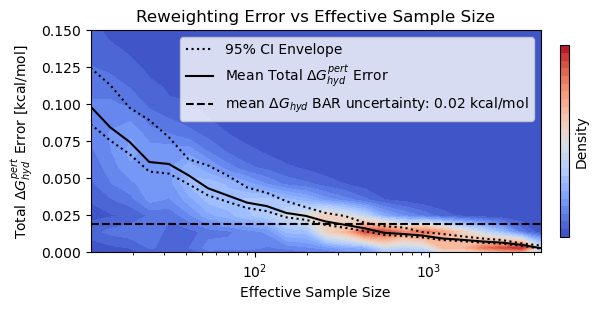

In [14]:
# Sample data
x = flat_ESSs
y = flat_total_errs / BETA / KCAL_TO_KJ
x_bins = np.exp(digit_log_bs_sizes)
y_bins = np.linspace(-0.1, 0.16, len(digit_log_bs_sizes))

hist, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins])

x_centers = 0.5 * (x_bins[:-1] + x_bins[1:])
y_centers = 0.5 * (y_bins[:-1] + y_bins[1:])

# Generate a grid of points
X, Y = np.meshgrid(x_centers, y_centers)
Z = hist.T


# Create the heatmap
fig, ax = plt.subplots(figsize=(6, 3))
heatmap = ax.contourf(X, Y, Z, levels=num_bins, cmap="coolwarm")
plt.colorbar(heatmap, ticks=[], label="Density", fraction=0.02, pad=0.04)
ax.set_xlim(np.exp(bs_log_midpoints)[0], np.exp(bs_log_midpoints)[-1])
ax.set_xscale('log')
ax.set_ylim(0., 0.15)

ax.plot(np.exp(bs_log_midpoints), errbias_lower_ci / BETA / KCAL_TO_KJ, color = 'k', ls = ':', label=f"95% CI Envelope")
ax.plot(np.exp(bs_log_midpoints), errbias_upper_ci / BETA / KCAL_TO_KJ, color = 'k', ls = ":")
ax.plot(np.exp(bs_log_midpoints), mean_err_bias / BETA / KCAL_TO_KJ, color = 'k', label=r"Mean Total $\Delta G_{hyd}^{pert}$ Error")

ax.axhline(y=arr_calc_dGs[:,1].mean() / BETA / KCAL_TO_KJ, color='k', linestyle='--', 
            label=r"mean $\Delta G_{hyd}$ BAR uncertainty: 0.02 kcal/mol")

ax.set_xlabel(f"Effective Sample Size")
ax.set_ylabel(r"Total $\Delta G_{hyd}^{pert}$ Error [kcal/mol]")
ax.legend()

#ax.set_aspect('equal')  # Keep plot square
plt.tight_layout()
plt.title(f"Reweighting Error vs Effective Sample Size")
plt.savefig("fig3_ESS_calibration.pdf", format="pdf", dpi=300)



cartoon plots

/scratch/choderaj/rufad/ipykernel_692311/2078191541.py:16: UserWarning: The following kwargs were not used by contour: 'lw'
  heatmap = plt.contourf(X, Y, Z, levels=50, cmap="coolwarm", lw=1)


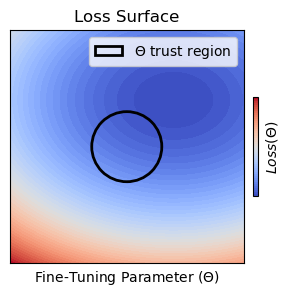

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define the quadratic function with a minimum at (2, 2)
def quadratic_function(x, y):
    return (x - 2)**2 + 2.*(y - 2)**2

# Generate a grid of points
x = np.linspace(-5, 5, 100)  # Extended to -3 for better centering
y = np.linspace(-5, 5, 100)  # Extended to -3 for better centering
X, Y = np.meshgrid(x, y)
Z = quadratic_function(X, Y)

# Create the heatmap
fig, ax = plt.subplots(figsize=(3, 3))
heatmap = plt.contourf(X, Y, Z, levels=50, cmap="coolwarm", lw=1)
plt.colorbar(heatmap, ticks=[], label=r"$Loss(\Theta)$", fraction=0.02, pad=0.04)

# Overlay dotted contour lines
#contour = plt.contour(X, Y, Z, levels=10, colors="black", linestyles=":")
#plt.clabel(contour, inline=True, fontsize=8, fmt="%.1f")  # Optional: add labels to contours

# Draw a dotted circle with radius 1 centered at the origin
circle = plt.Circle((0, 0), 1.5, color="black", linestyle="-", fill=False, lw=2, label=r"$\Theta$ trust region")
plt.gca().add_patch(circle)

# Set plot limits to center about the origin
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')


plt.xticks([])  # Remove x ticks
plt.yticks([])  # Remove y ticks

# Show the plot
plt.title(f"Loss Surface")
plt.xlabel(r"Fine-Tuning Parameter ($\Theta$)")
plt.legend()
plt.tight_layout()
plt.savefig("fig3_loss_surface_cartoon.pdf", format="pdf", dpi=300)


density changes cartoon

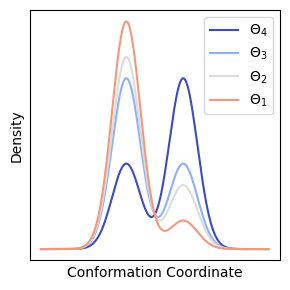

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the Gaussian mixture
mu1, mu2 = -1, 1          # Means of the two distributions
sigma1, sigma2 = 0.5, 0.5     # Standard deviations (both standard normal)
weights1, weights2 = [1/3, 2/3, 3/4, 8/9], [2/3, 1/3, 1/4, 1/9]  # Weights for each distribution

# Range for the x-axis
x = np.linspace(-4, 4, 500)
_iter = 0.
idx = 0
fig, ax = plt.subplots(figsize=(3, 3))
for weight1, weight2 in zip(weights1, weights2):
    # Gaussian distributions
    y1 = weight1 * norm.pdf(x, mu1, sigma1)
    y2 = weight2 * norm.pdf(x, mu2, sigma2)
    
    # Combined density
    y = y1 + y2
    _ls = '-'
    plt.plot(x, y, color=plt.cm.coolwarm(_iter), label=f"$\Theta_{4 - idx}$", ls = _ls)
    _iter += 1/4
    idx += 1

# Plot
plt.xlabel("Conformation Coordinate")
plt.ylabel("Density")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
#plt.title("1D Gaussian Mixture Model Density Plot")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.savefig("fig3_cartoon_probability_change.pdf", format="pdf", dpi=300)


rerun optimization with and without ESS to observe model parameter, ESS, and residual behavior as a function of training iteration.

In [19]:
# make wrapper
nESS_break_threshold = 0.1
allowed_failures = 10 # this is a heuristic. I just want to be able to observe a few BFGS optimization steps before 
# failing out (i.e. ESS falls below threshold in training data.)

# noESS wrapper
noESS_wrapper = Wrapper(
        exp_dgs = jnp.array(arr_exp_dGs[:,0]),
        orig_calc_dgs = jnp.array(arr_calc_dGs[:,0]),
        orig_calc_ddgs = jnp.array(arr_calc_dGs[:,1]),
        tm_ligand_charges = tm_ligand_charges, # tm
        hs = hs, 
        es = es,
        ss = ss,
        prefactors = prefactors,
        num_pcs = eigval_idx+1,
        retrieve_by_descent = False,
        retrieval_seed = jax.random.PRNGKey(48),
        train_fraction = 0.5, # use half data to train.
        test_fraction = 0.4, # we don't actually use this since it is for calibration
        nESS_frac_threshold = 0.0,
        nESS_coeff = 10.,
        nESS_on_test = False,
        mlp_init_params=None #(2, 1)
)

noESS_wrapper._prev_params = noESS_wrapper.model_params
noESS_wrapper._params_collector = [noESS_wrapper.model_params]
noESS_wrapper._ESS_collector = []
noESS_wrapper._delta_us_collector = []
noESS_wrapper._callback_counter = 0

# ESS wrapper
ESS_wrapper = Wrapper(
        exp_dgs = jnp.array(arr_exp_dGs[:,0]),
        orig_calc_dgs = jnp.array(arr_calc_dGs[:,0]),
        orig_calc_ddgs = jnp.array(arr_calc_dGs[:,1]),
        tm_ligand_charges = tm_ligand_charges, # tm
        hs = hs, 
        es = es,
        ss = ss,
        prefactors = prefactors,
        num_pcs = eigval_idx+1,
        retrieve_by_descent = False,
        retrieval_seed = jax.random.PRNGKey(48),
        train_fraction = 0.5, # use half data to train.
        test_fraction = 0.4, # we don't actually use this since it is for calibration
        nESS_frac_threshold = 0.15,
        nESS_coeff = 100.,
        nESS_on_test = False,
        mlp_init_params=None #(2, 1)
)

ESS_wrapper._prev_params = ESS_wrapper.model_params
ESS_wrapper._params_collector = [ESS_wrapper.model_params]
ESS_wrapper._ESS_collector = []
ESS_wrapper._delta_us_collector = []
ESS_wrapper._callback_counter = 0



# need to make a modification of validate callback if we want to STOP optimization if any ESS 
def callback(flat_params, *args, wrapper):
    # _ = wrapper.validate_callback(flat_params, *args) # early stopping if validate falls outside of 95% ci
    wrapper._callback_counter += 1
    params = flat_params.reshape(*wrapper.model_params.shape)
    wrapper._params_collector.append(params)
    train_loss_vals, train_loss_auxs = wrapper.train_loss_fn(params)
    (train_nESSs, tr_delta_us, tr_orig_calc_dg, 
         tr_reweighted_solv_dg, tr_reweighted_solv_ddg, 
         tr_exp_dg, tr_ligand_tm_charges, tr_orig_es_ss, tr_mod_es_ss) = train_loss_auxs
    wrapper._ESS_collector.append(train_nESSs)
    wrapper._delta_us_collector.append(tr_delta_us)
    try:
        assert np.sum(train_nESSs < nESS_break_threshold) < allowed_failures
    except Exception as e:
        print(e)
        raise ValueError(f"nESS threshold surpassed")
    wrapper._prev_params = params

In [20]:
noESS_res = scipy.optimize.minimize(
    noESS_wrapper, noESS_wrapper.flat_params, 
    method = 'BFGS', 
    jac = noESS_wrapper.jac, 
    callback=functools.partial(callback, wrapper = noESS_wrapper))

ValueError: nESS threshold surpassed

In [21]:
ESS_res = scipy.optimize.minimize(
    ESS_wrapper, ESS_wrapper.flat_params, 
    method = 'BFGS', 
    jac = ESS_wrapper.jac, 
    callback=functools.partial(callback, wrapper = ESS_wrapper))

In [22]:
# retrieve indices that fell below threshold
noESS_break_indices = np.where(noESS_wrapper._ESS_collector[-1] < nESS_break_threshold)[0]
ESS_break_indices = np.where(ESS_wrapper._ESS_collector[-1] < nESS_break_threshold)[0] # this is empty

In [23]:
noESS_break_indices

array([  5,  25,  48,  54,  69,  79,  82, 121, 126, 134, 153, 155, 179,
       181, 186, 191, 194, 198, 208, 225, 236, 245, 259, 292])

In [24]:
# molecule choice is 54

In [25]:
# retrieve ESSs and delta_us for all `break_indices`
noESS_collections = [q[noESS_break_indices] for q in noESS_wrapper._ESS_collector]
ESS_collections = [q[noESS_break_indices] for q in ESS_wrapper._ESS_collector]
#print(ESS_collections)

noESS_delta_us_collections = [q[noESS_break_indices] for q in noESS_wrapper._delta_us_collector]
ESS_delta_us_collections = [q[noESS_break_indices] for q in ESS_wrapper._delta_us_collector]

# retrieve the perturbation free energy 
noESS_dg_collections = np.array([[abs_dg_reweighting_zwanzig(dus, dus*0., 0., 0.)[0] for dus in q] for q in noESS_delta_us_collections])
noESS_ddg_collections = np.array([[abs_dg_reweighting_zwanzig(dus, dus*0., 0., 0.)[1][1] for dus in q] for q in noESS_delta_us_collections])
ESS_dg_collections = np.array([[abs_dg_reweighting_zwanzig(dus, dus*0., 0., 0.)[0] for dus in q] for q in ESS_delta_us_collections])
ESS_ddg_collections = np.array([[abs_dg_reweighting_zwanzig(dus, dus*0., 0., 0.)[1][1] for dus in q] for q in ESS_delta_us_collections])

# now retrieve the 0th mol that fell out
choice_idx = 3 # this one empirically gives a bit of dynamic range in ESS (looking at `noESS_break_indices`, it is molecule 54)
noESS_my_ESS_collections = np.array([1.] + [q[choice_idx] for q in noESS_collections]) * 5000 # 5000 snapshots
noESS_my_dg_collections = np.concatenate([np.array([0.]), noESS_dg_collections[:,choice_idx]]) / BETA / KCAL_TO_KJ
noESS_my_ddg_collections = np.concatenate([np.array([0.]), noESS_ddg_collections[:,choice_idx]]) / BETA / KCAL_TO_KJ

ESS_my_ESS_collections = np.array([1.] + [q[choice_idx] for q in ESS_collections]) * 5000 # 5000 snapshots
ESS_my_dg_collections = np.concatenate([np.array([0.]), ESS_dg_collections[:,choice_idx]]) / BETA / KCAL_TO_KJ
ESS_my_ddg_collections = np.concatenate([np.array([0.]), ESS_ddg_collections[:,choice_idx]]) / BETA / KCAL_TO_KJ

In [26]:
# we want to compute the l2 norm of the parameter matrices
noESS_l2_norms = np.array([np.linalg.svd(A, compute_uv=False)[0] for A in noESS_wrapper._params_collector])
ESS_l2_norms = np.array([np.linalg.svd(A, compute_uv=False)[0] for A in ESS_wrapper._params_collector])

In [31]:
noESS_break_indices

array([  5,  25,  48,  54,  69,  79,  82, 121, 126, 134, 153, 155, 179,
       181, 186, 191, 194, 198, 208, 225, 236, 245, 259, 292])

In [32]:
out_names[54]

'mobley_1781152'

^that is the name of the molecule in FreeSolv

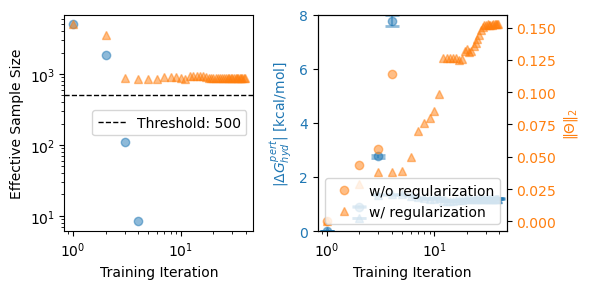

In [29]:
from matplotlib.ticker import MaxNLocator
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


fig, axes = plt.subplots(1, 2, figsize=(6, 3))
[axes[q].xaxis.set_major_locator(MaxNLocator(integer=True)) for q in range(2)]

# ESS change
axes[0].plot(np.arange(len(noESS_my_ESS_collections))+1, 
             noESS_my_ESS_collections, marker = 'o', ls='none', alpha=0.5)
axes[0].plot(np.arange(len(ESS_my_ESS_collections))+1, 
             ESS_my_ESS_collections, marker = '^', ls='none', alpha=0.5)
axes[0].set_ylabel("Effective Sample Size")
axes[0].axhline(y=500, color='k', linestyle='--', linewidth=1, label="Threshold: 500")
axes[0].set_xlabel(f"Training Iteration")
axes[0].set_yscale('log')
axes[0].set_xscale('log')

axes[0].legend()
# axes[0].set_title(f"Effective Sample Size per Training Iteration")

ax1 = axes[1]

# dG perturbation
ax1.errorbar(
    np.arange(len(noESS_my_dg_collections))+1, np.abs(noESS_my_dg_collections), yerr = noESS_my_ddg_collections, 
    marker = 'o', capsize=5, capthick=2, ls='none', color = default_colors[0], alpha = 0.5
)
ax1.errorbar(
    np.arange(len(ESS_my_dg_collections))+1, np.abs(ESS_my_dg_collections), yerr = ESS_my_ddg_collections, 
    marker = '^', capsize=5, capthick=2, ls='none', color = default_colors[0], alpha = 0.5
)
ax1.set_xlabel(f"Training Iteration")

ax1.set_ylabel(r"$ | \Delta G_{hyd}^{pert} | $ [kcal/mol]", color = default_colors[0])
ax1.tick_params(axis='y', labelcolor=default_colors[0])
ax1.set_ylim(0., 8.)



ax2 = ax1.twinx()
ax2.plot(np.arange(len(noESS_l2_norms)) + 1, noESS_l2_norms, marker = 'o', ls='none', color = default_colors[1], alpha = 0.5, label=f"w/o regularization")
ax2.plot(np.arange(len(ESS_l2_norms)) + 1, ESS_l2_norms, marker = '^', ls='none', color = default_colors[1], alpha = 0.5, label=f"w/ regularization")
#ax2.set_ylim(0., 0.25)
ax2.legend()


ax2.set_ylabel(r"$  \| \Theta \| _2$", color = default_colors[1])
ax2.tick_params(axis='y', labelcolor=default_colors[1])
ax2.set_xlabel(f"training interation")
ax1.set_xscale('log')


plt.tight_layout()
plt.savefig("Fig3_ESS_l2norm_per_iteration.pdf", format="pdf", dpi=300)